Instalar dependências
python
Copiar
Editar


In [1]:
# Instalação do Prophet e do openpyxl para ler arquivos Excel
!pip install prophet openpyxl --quiet


 Importação de bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from google.colab import files
from io import BytesIO


Upload e leitura do arquivo Excel

In [3]:
# 📁 Carregar Dados
# =========================================
uploaded = files.upload()
df_original = pd.read_excel(next(iter(uploaded)))


Saving OrganizationType_Count_v4_semajust (1)_tratado_v2.xlsx to OrganizationType_Count_v4_semajust (1)_tratado_v2.xlsx


In [9]:

# Faz uma cópia do DataFrame original para evitar alterações permanentes
df = df_original.copy()

# Função para ajustar datas incompletas (ano ou ano/mês) e tratá-las como datas válidas
def ajustar_datas(data_str):
    try:
        if len(data_str) == 4:  # Somente ano (ex: '2005') → assume '01-01'
            return pd.NaT
        elif len(data_str) == 7:  # Ano e mês (ex: '2005-09') → assume dia '01'
            return pd.Timestamp(data_str + '-01')
        else:  # Data completa (ex: '2005-09-22')
            return pd.Timestamp(data_str)
    except:
        return pd.NaT  # Retorna valor nulo se a conversão falhar

# Aplica a função de ajuste à coluna de datas
df['Date Breach'] = df['Date Breach'].apply(ajustar_datas)

# Converte a coluna para o tipo datetime do Pandas
df.loc[:, 'Date Breach'] = pd.to_datetime(df['Date Breach'])

# Define a coluna de data como índice do DataFrame
df.set_index('Date Breach', inplace=True)

# Garante que o índice está em formato datetime (reforço de segurança)
df.index = pd.to_datetime(df.index)

# Filtra para manter apenas dados entre 2010 e 2023
df = df[(df.index >= pd.to_datetime('2010-01-01')) & (df.index < pd.to_datetime('2024-01-01'))]

# Extrai a série temporal do setor atual, com frequência mensal
serie = df.resample('ME').sum().fillna(0)

# Mostra 20 linhas aleatórias do DataFrame
print(serie.sample(10))


              BSF   BSO   BSR   EDU   GOV   MED   NGO   UNKN  Total Geral
Date Breach                                                              
2015-09-30    8.0  13.0  27.0   1.0   6.0  23.0   0.0   42.0        120.0
2023-09-30   30.0  83.0  16.0  16.0   8.5  62.0  28.0   96.5        355.5
2013-03-31    6.0  10.0  12.0  13.0   2.0  13.0   0.0   26.0         82.0
2017-12-31   16.0  35.0  30.0  15.0   6.0  28.0   4.0   66.5        208.0
2022-09-30   44.0  72.0  20.0  19.0  13.0  42.0   8.0   86.5        312.0
2016-04-30   22.0  51.0  39.0  17.0   3.0  39.0  17.0  120.5        315.5
2022-08-31   57.0  70.5   4.0  32.0   9.0  33.0  14.0   79.0        304.0
2021-04-30   50.0  96.5  27.0  24.0   8.0  76.0  15.0  133.0        449.0
2015-10-31   13.0  21.5  35.0   6.0   1.0  32.0   3.0   52.5        169.0
2017-04-30   14.0  18.0  47.0  25.0   6.0  44.0   7.0   70.5        245.0


In [10]:
# Limpeza e estruturação
# df = df[df['Date Breach'] != 'UNKN'] # This line was causing the error
# Since 'Date Breach' is now the index, we need to filter it using the index
df = df[df.index != 'UNKN']
df.index = pd.to_datetime(df.index) # Convert index to datetime
# df['Date Breach'] = pd.to_datetime(df['Date Breach']) # This line is no longer needed
# df.set_index('Date Breach', inplace=True) # This line is no longer needed

# Seleção e preenchimento
cols = ['BSF', 'BSO', 'BSR', 'EDU', 'GOV', 'MED', 'NGO', 'Total Geral','UNKN']
df = df[cols].fillna(0)

# Reamostragem e filtro até 2024
df_monthly = df.resample('ME').sum()
df_filtered = df_monthly[df_monthly.index <= '2024-12-31']
# Mostra 20 linhas aleatórias do DataFrame
print(serie.sample(10))

              BSF   BSO   BSR   EDU   GOV   MED   NGO   UNKN  Total Geral
Date Breach                                                              
2019-05-31   21.0  52.5  17.0  10.0   5.0  60.0   5.0   59.0        232.5
2018-08-31   24.0  31.0  53.0   4.0   5.0  44.0  11.0   84.5        263.0
2018-04-30   31.0  49.0  35.0   7.0   5.0  45.0   6.5   88.0        271.5
2021-07-31   48.0  78.0  25.0  22.0   6.0  60.0  19.0  112.0        384.5
2023-08-31   39.0  73.5  30.0  36.0   5.0  57.0  11.0   80.0        336.0
2017-10-31   34.0  47.5  27.0   4.0  12.0  32.0   2.0   60.5        210.0
2010-08-31    2.0   0.0   3.0   1.0   0.0   9.0   0.0    3.0         19.0
2016-04-30   22.0  51.0  39.0  17.0   3.0  39.0  17.0  120.5        315.5
2017-06-30   39.0  30.0  19.0  15.0  13.0  33.0   9.0   54.0        219.0
2021-10-31   35.0  96.0  19.0  11.0  15.0  89.0  14.5  139.5        421.0


Preparação e treino do modelo Prophet

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1hmpobpy/v34cmi06.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1hmpobpy/rciqp3ij.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44615', 'data', 'file=/tmp/tmp1hmpobpy/v34cmi06.json', 'init=/tmp/tmp1hmpobpy/rciqp3ij.json', 'output', 'file=/tmp/tmp1hmpobpy/prophet_model_f9m4det/prophet_model-20250410203725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:37:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:37:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/


📊 Resultados para BSF
MAE:  13.21
RMSE: 15.37
MAPE: 39.47
Melhores parâmetros: {'changepoint_prior_scale': 0.05, 'fourier_order': 15, 'n_changepoints': 50}


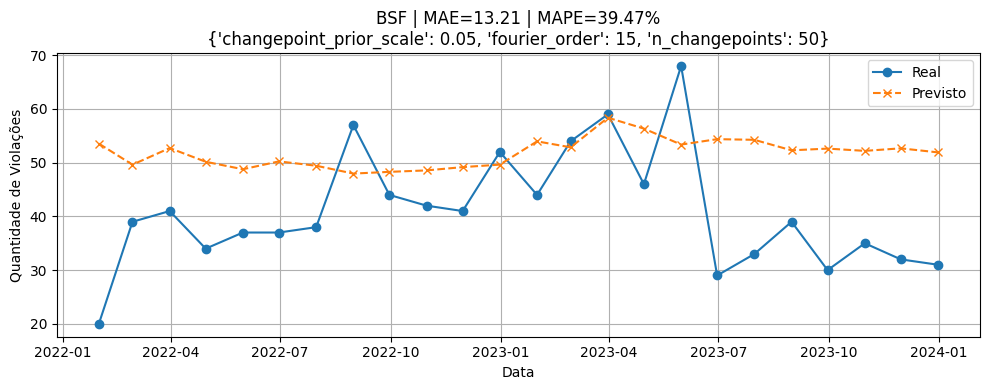

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1hmpobpy/hka_3zx5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1hmpobpy/43te70fo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31123', 'data', 'file=/tmp/tmp1hmpobpy/hka_3zx5.json', 'init=/tmp/tmp1hmpobpy/43te70fo.json', 'output', 'file=/tmp/tmp1hmpobpy/prophet_modelx_1wqy_b/prophet_model-20250410203729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:37:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:37:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/


📊 Resultados para BSO
MAE:  23.26
RMSE: 25.91
MAPE: 32.13
Melhores parâmetros: {'changepoint_prior_scale': 0.05, 'fourier_order': 15, 'n_changepoints': 25}


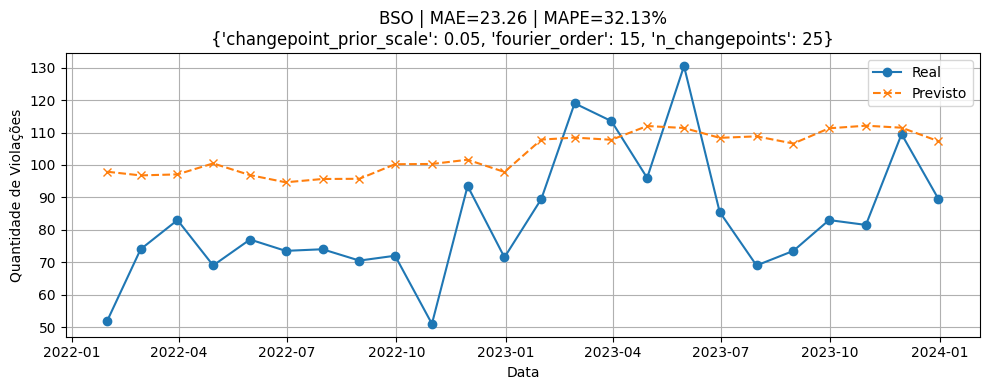

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1hmpobpy/3v6cue3b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1hmpobpy/wm123lo3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22644', 'data', 'file=/tmp/tmp1hmpobpy/3v6cue3b.json', 'init=/tmp/tmp1hmpobpy/wm123lo3.json', 'output', 'file=/tmp/tmp1hmpobpy/prophet_model_txd29op/prophet_model-20250410203733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:37:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:37:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/


📊 Resultados para BSR
MAE:  7.10
RMSE: 8.73
MAPE: 73.13
Melhores parâmetros: {'changepoint_prior_scale': 0.1, 'fourier_order': 5, 'n_changepoints': 50}


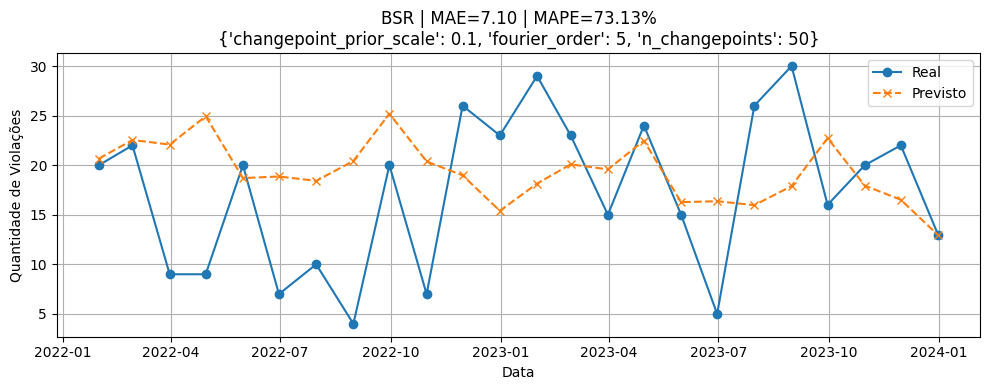

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1hmpobpy/q3aqyzj3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1hmpobpy/7rnz_f8_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63907', 'data', 'file=/tmp/tmp1hmpobpy/q3aqyzj3.json', 'init=/tmp/tmp1hmpobpy/7rnz_f8_.json', 'output', 'file=/tmp/tmp1hmpobpy/prophet_modell6cjibru/prophet_model-20250410203737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:37:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:37:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/


📊 Resultados para EDU
MAE:  10.43
RMSE: 13.70
MAPE: 36.29
Melhores parâmetros: {'changepoint_prior_scale': 0.1, 'fourier_order': 10, 'n_changepoints': 25}


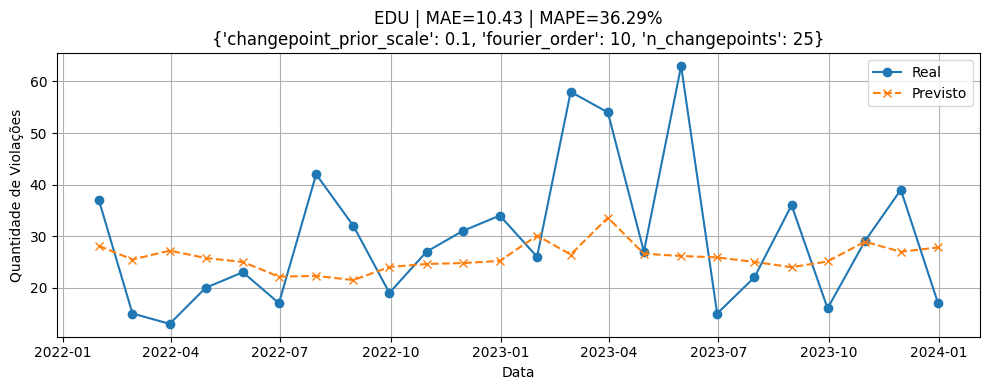

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1hmpobpy/zikeyvze.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1hmpobpy/pgw44_rd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23501', 'data', 'file=/tmp/tmp1hmpobpy/zikeyvze.json', 'init=/tmp/tmp1hmpobpy/pgw44_rd.json', 'output', 'file=/tmp/tmp1hmpobpy/prophet_modelgovleblj/prophet_model-20250410203742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:37:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:37:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/


📊 Resultados para GOV
MAE:  4.00
RMSE: 5.39
MAPE: 40.17
Melhores parâmetros: {'changepoint_prior_scale': 0.3, 'fourier_order': 5, 'n_changepoints': 50}


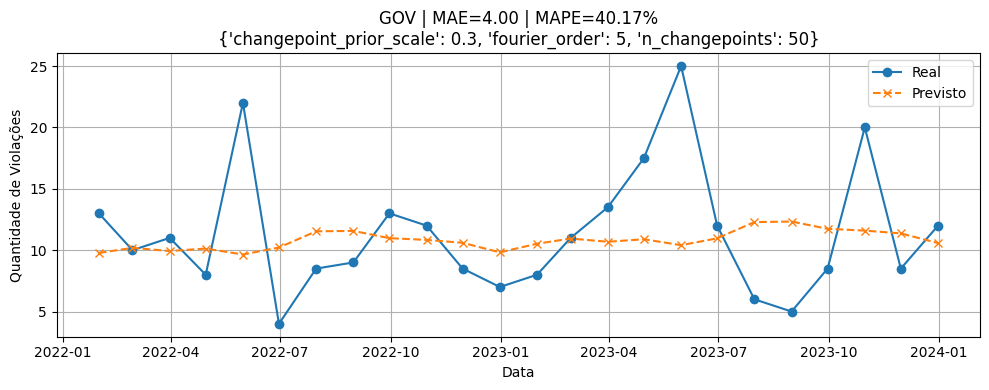

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1hmpobpy/w61uquvg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1hmpobpy/vtmbg0yb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70298', 'data', 'file=/tmp/tmp1hmpobpy/w61uquvg.json', 'init=/tmp/tmp1hmpobpy/vtmbg0yb.json', 'output', 'file=/tmp/tmp1hmpobpy/prophet_model2mlglixk/prophet_model-20250410203746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:37:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:37:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/


📊 Resultados para MED
MAE:  15.53
RMSE: 18.20
MAPE: 26.54
Melhores parâmetros: {'changepoint_prior_scale': 0.05, 'fourier_order': 15, 'n_changepoints': 50}


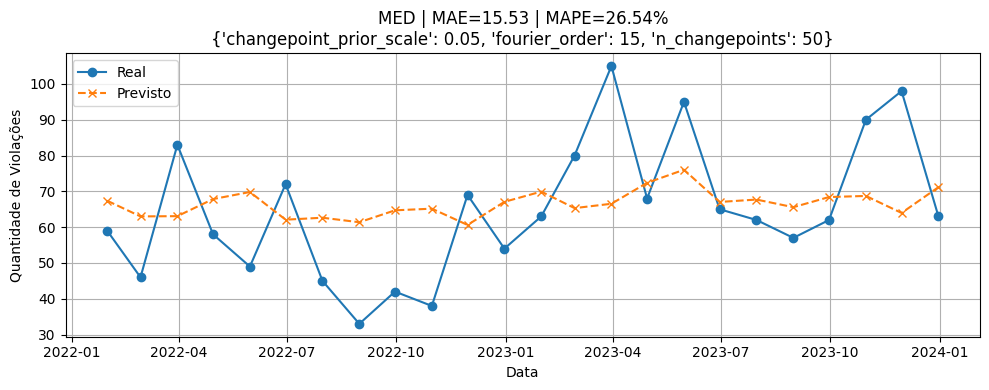

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1hmpobpy/s263vlj6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1hmpobpy/_zwmixfl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32487', 'data', 'file=/tmp/tmp1hmpobpy/s263vlj6.json', 'init=/tmp/tmp1hmpobpy/_zwmixfl.json', 'output', 'file=/tmp/tmp1hmpobpy/prophet_model_gemattv/prophet_model-20250410203751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:37:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:37:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/


📊 Resultados para NGO
MAE:  5.42
RMSE: 6.08
MAPE: 48.75
Melhores parâmetros: {'changepoint_prior_scale': 0.05, 'fourier_order': 5, 'n_changepoints': 50}


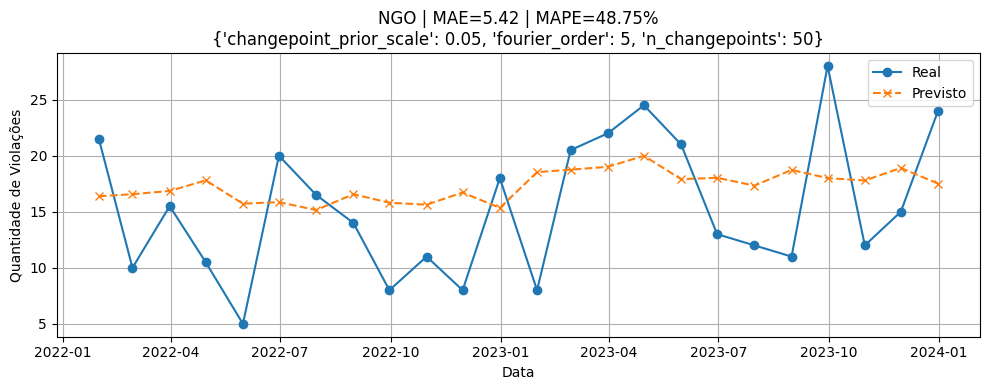

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1hmpobpy/3e7rcg3l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1hmpobpy/b6zwavj8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53591', 'data', 'file=/tmp/tmp1hmpobpy/3e7rcg3l.json', 'init=/tmp/tmp1hmpobpy/b6zwavj8.json', 'output', 'file=/tmp/tmp1hmpobpy/prophet_model2jecf6rv/prophet_model-20250410203756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:37:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:37:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/


📊 Resultados para Total Geral
MAE:  61.73
RMSE: 69.66
MAPE: 17.63
Melhores parâmetros: {'changepoint_prior_scale': 0.05, 'fourier_order': 15, 'n_changepoints': 25}


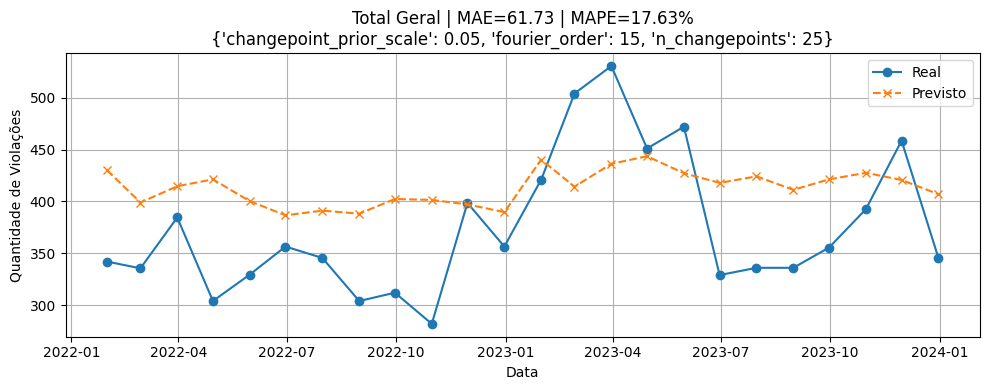

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1hmpobpy/9k1nhp77.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1hmpobpy/by5vi_jj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50085', 'data', 'file=/tmp/tmp1hmpobpy/9k1nhp77.json', 'init=/tmp/tmp1hmpobpy/by5vi_jj.json', 'output', 'file=/tmp/tmp1hmpobpy/prophet_model1t8z0q0c/prophet_model-20250410203801.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:38:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:38:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/


📊 Resultados para UNKN
MAE:  21.41
RMSE: 24.87
MAPE: 22.54
Melhores parâmetros: {'changepoint_prior_scale': 0.1, 'fourier_order': 15, 'n_changepoints': 50}


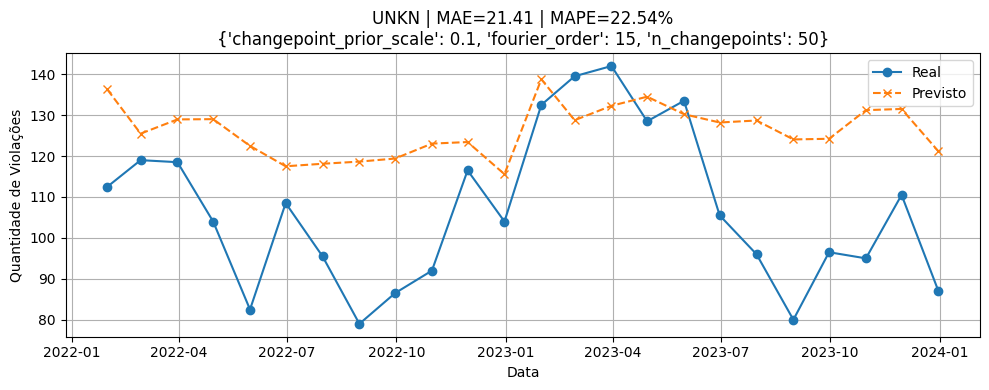

        Coluna    MAE   RMSE   MAPE  changepoint_prior_scale  fourier_order  \
0          BSF  13.21  15.37  39.47                     0.05             15   
1          BSO  23.26  25.91  32.13                     0.05             15   
2          BSR   7.10   8.73  73.13                     0.10              5   
3          EDU  10.43  13.70  36.29                     0.10             10   
4          GOV   4.00   5.39  40.17                     0.30              5   
5          MED  15.53  18.20  26.54                     0.05             15   
6          NGO   5.42   6.08  48.75                     0.05              5   
7  Total Geral  61.73  69.66  17.63                     0.05             15   
8         UNKN  21.41  24.87  22.54                     0.10             15   

   n_changepoints   Status  
0              50  Sucesso  
1              25  Sucesso  
2              50  Sucesso  
3              25  Sucesso  
4              50  Sucesso  
5              50  Sucesso  
6     

In [11]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# Parâmetros a testar no grid search
changepoint_values = [0.05, 0.1, 0.3, 0.5]
fourier_orders = [5, 10, 15]
n_changepoints_values = [25, 50]

param_grid = list(itertools.product(changepoint_values, fourier_orders, n_changepoints_values))

# Armazena os resultados
resultados_prophet = []

def aplicar_prophet_serie(nome_coluna, df_series):
    df_temp = df_series[[nome_coluna]].copy()
    df_temp = df_temp.rename(columns={nome_coluna: 'y'})
    df_temp['ds'] = df_temp.index
    df_temp = df_temp[['ds', 'y']]

    train = df_temp[:-24]
    test = df_temp[-24:]

    best_model = None
    best_forecast = None
    best_metrics = {'mae': np.inf}
    best_params = None

    for changepoint_prior_scale, fourier_order, n_changepoints in param_grid:
        try:
            model = Prophet(
                yearly_seasonality=False,
                changepoint_prior_scale=changepoint_prior_scale,
                n_changepoints=n_changepoints
            )

            model.add_seasonality(
                name='anual',
                period=365.25,
                fourier_order=fourier_order
            )

            model.fit(train)

            future = model.make_future_dataframe(periods=24, freq='M')
            forecast = model.predict(future)

            forecast_test = forecast.set_index('ds').loc[test['ds']]
            predicted = forecast_test['yhat'].values
            actual = test['y'].values

            mae = mean_absolute_error(actual, predicted)
            rmse = np.sqrt(mean_squared_error(actual, predicted))
            mape = np.mean(np.abs((actual - predicted) / actual)) * 100

            if mae < best_metrics['mae']:
                best_model = model
                best_forecast = forecast
                best_metrics = {'mae': mae, 'rmse': rmse, 'mape': mape}
                best_params = {
                    'changepoint_prior_scale': changepoint_prior_scale,
                    'fourier_order': fourier_order,
                    'n_changepoints': n_changepoints
                }

        except Exception as e:
            print(f"Erro em {nome_coluna} - params={changepoint_prior_scale}, {fourier_order}, {n_changepoints}: {e}")
            continue

    if best_model is None:
        print(f"⚠️ Nenhum modelo válido para {nome_coluna}. Registrando com falha.")
        resultados_prophet.append({
            'Coluna': nome_coluna,
            'MAE': None,
            'RMSE': None,
            'MAPE': None,
            'changepoint_prior_scale': None,
            'fourier_order': None,
            'n_changepoints': None,
            'Status': 'Erro no ajuste'
        })
        return

    # Plot + registro dos resultados válidos
    forecast_test = best_forecast.set_index('ds').loc[test['ds']]
    predicted = forecast_test['yhat'].values
    actual = test['y'].values

    print(f"\n📊 Resultados para {nome_coluna}")
    print(f"MAE:  {best_metrics['mae']:.2f}")
    print(f"RMSE: {best_metrics['rmse']:.2f}")
    print(f"MAPE: {best_metrics['mape']:.2f}")
    print(f"Melhores parâmetros: {best_params}")

    plt.figure(figsize=(10, 4))
    plt.plot(test['ds'], actual, marker='o', label='Real')
    plt.plot(test['ds'], predicted, marker='x', linestyle='--', label='Previsto')
    plt.title(f"{nome_coluna} | MAE={best_metrics['mae']:.2f} | MAPE={best_metrics['mape']:.2f}%\n{best_params}")
    plt.xlabel('Data')
    plt.ylabel('Quantidade de Violações')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    resultados_prophet.append({
        'Coluna': nome_coluna,
        'MAE': round(best_metrics['mae'], 2),
        'RMSE': round(best_metrics['rmse'], 2),
        'MAPE': round(best_metrics['mape'], 2),
        'changepoint_prior_scale': best_params['changepoint_prior_scale'],
        'fourier_order': best_params['fourier_order'],
        'n_changepoints': best_params['n_changepoints'],
        'Status': 'Sucesso'
    })


# Aplicar para todas as colunas
for col in df_filtered.columns:
    if df_filtered[col].sum() > 0:
        aplicar_prophet_serie(col, df_filtered)

# Salvar resultados em CSV
df_resultados_prophet = pd.DataFrame(resultados_prophet)
print(df_resultados_prophet)
df_resultados_prophet.to_csv('resultados_prophet_gridsearch.csv', index=False)


Aplicar para todas as categorias (incluindo BSO)

Interpretação das métricas:
MAE (27,35%):
Indica que, em média, o modelo Prophet errou aproximadamente 27% em relação ao valor real. Embora aceitável, esse valor sugere que há espaço para melhorar a precisão.

RMSE (32,19%):
Como o RMSE penaliza mais os erros grandes, um valor de cerca de 32% sinaliza que o Prophet teve dificuldades em capturar com precisão algumas variações mais acentuadas na série temporal. Não é um resultado ruim, mas sugere volatilidade nos dados históricos.

MAPE (32,88%):
Mostra que, em média, cada previsão do Prophet desvia cerca de 33% do valor real observado. Esse valor é moderado, mas normalmente buscamos MAPE inferior a 20% para considerar uma previsão altamente confiável.

Avaliação Geral:
O resultado do Prophet (MAPE ~33%) é razoável, mas apresenta margem significativa para melhora. A comparação com o desempenho anterior do ARIMA para a categoria BSO (MAPE ~8,64%) mostra claramente que:

O modelo ARIMA teve desempenho superior (MAPE ~8,64%), mostrando melhor adequação para essa categoria específica.

O modelo Prophet, embora robusto e eficaz em muitos contextos, encontrou maior dificuldade em prever essa série com a janela de teste mais longa (24 meses), possivelmente pela ocorrência de eventos ou picos inesperados nos últimos anos.

Sugestões para melhoria:
Experimentar o uso de variáveis externas (por exemplo, eventos de segurança, regulamentações, campanhas específicas) para aprimorar a precisão do Prophet.

Considerar a possibilidade de ajustar parâmetros do Prophet, como a inclusão de tendências sazonais ou alterações na periodicidade.

Avaliar o uso combinado dos modelos Prophet e ARIMA para gerar uma previsão mais robusta (abordagem híbrida).

Conclusão:
O Prophet demonstrou razoável capacidade de previsão para a categoria BSO, mas apresentou desempenho inferior ao ARIMA neste contexto específico. Recomenda-se considerar ajustes adicionais ou abordagens híbridas para alcançar melhores resultados.